In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from glob import glob
from dtaidistance import dtw
from sklearn_extra.cluster import KMedoids
from sklearn.feature_extraction.text import CountVectorizer
from pyclustering.cluster.kmedoids import kmedoids

In [3]:
a = [1,2,3,4,3,0]
b = [2,3,5,6,0,0]
dtw.distance(a,b)

3.3166247903554

In [4]:
# meta data includes the course title, run dates
AM_meta = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-meta.csv')
AM_meta

,id,metadata.display_name,category,metadata.start,metadata.end,metadata.enrollment_start,metadata.enrollment_end
0,MITxPRO+AMxB+1T2018,Additive Manufacturing for Innovative Design a...,course,2018-04-30 04:00:00,2018-07-02 23:30:00,2018-03-06,2018-05-11 23:30:00


In [5]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')
AM_modules

,id,mod_hex_id,courseID,mod_type,name,markdown,order,childOrder,treelevel,chpModPar,seqModPar,vrtModPar,parent,modparent_childlevel
0,block-v1:MITxPRO+AMxB+1T2018+type@course+block...,course,MITxPRO+AMxB+1T2018,course,Additive Manufacturing for Innovative Design a...,NaN,1,0,0,NaN,NaN,NaN,course,course/0
1,block-v1:MITxPRO+AMxB+1T2018+type@chapter+bloc...,b9dd2cb6d3a44e96aedb515388e02405,MITxPRO+AMxB+1T2018,chapter,"Entrance Survey (5 min, required)",NaN,2,1,1,b9dd2cb6d3a44e96aedb515388e02405,NaN,NaN,course,course/1
2,block-v1:MITxPRO+AMxB+1T2018+type@sequential+b...,5589ca87f02147ec8452cead30cc4d5f,MITxPRO+AMxB+1T2018,sequential,"Entrance Survey (5 min, required)",NaN,3,1,2,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,NaN,b9dd2cb6d3a44e96aedb515388e02405,b9dd2cb6d3a44e96aedb515388e02405/1
3,block-v1:MITxPRO+AMxB+1T2018+type@vertical+blo...,57c4192d1f714350848b1424ce840c75,MITxPRO+AMxB+1T2018,vertical,Entrance Survey,NaN,4,1,3,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,5589ca87f02147ec8452cead30cc4d5f,5589ca87f02147ec8452cead30cc4d5f/1
4,block-v1:MITxPRO+AMxB+1T2018+type@html+block@4...,401ee1f6f3684be7b6124490f34adc5a,MITxPRO+AMxB+1T2018,html,NaN,NaN,5,1,4,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,57c4192d1f714350848b1424ce840c75,57c4192d1f714350848b1424ce840c75/1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,block-v1:MITxPRO+AMxB+1T2018+type@vertical+blo...,e4cd156124f04c1ab2c7fbeead3afa35,MITxPRO+AMxB+1T2018,vertical,Test Icons Betsy,NaN,1117,1,3,4022bcb994a3447a9c609f4ce5bd9016,9852b66b25d14ec0b379bc6532e1753c,e4cd156124f04c1ab2c7fbeead3afa35,9852b66b25d14ec0b379bc6532e1753c,9852b66b25d14ec0b379bc6532e1753c/1
1117,block-v1:MITxPRO+AMxB+1T2018+type@html+block@0...,024fed17849e4d60bfc86afa47ce9cb4,MITxPRO+AMxB+1T2018,html,NaN,NaN,1118,1,4,4022bcb994a3447a9c609f4ce5bd9016,9852b66b25d14ec0b379bc6532e1753c,e4cd156124f04c1ab2c7fbeead3afa35,e4cd156124f04c1ab2c7fbeead3afa35,e4cd156124f04c1ab2c7fbeead3afa35/1
1118,block-v1:MITxPRO+AMxB+1T2018+type@sequential+b...,48c79ba223a744da8b90de81cedef224,MITxPRO+AMxB+1T2018,sequential,Beta Instructions,NaN,1119,2,2,4022bcb994a3447a9c609f4ce5bd9016,48c79ba223a744da8b90de81cedef224,NaN,4022bcb994a3447a9c609f4ce5bd9016,4022bcb994a3447a9c609f4ce5bd9016/2
1119,block-v1:MITxPRO+AMxB+1T2018+type@vertical+blo...,288150e9a6b847498df4824e03333ba0,MITxPRO+AMxB+1T2018,vertical,Beta Instructions,NaN,1120,1,3,4022bcb994a3447a9c609f4ce5bd9016,48c79ba223a744da8b90de81cedef224,288150e9a6b847498df4824e03333ba0,48c79ba223a744da8b90de81cedef224,48c79ba223a744da8b90de81cedef224/1


In [6]:
# session level edge data
AM_edges_sessionLevel01 = pd.read_csv('data/MITxPRO+AMxB+1T2018/edges/MITxPRO+AMxB+1T2018-stdAgg-edgeList-sessionLevel-1.csv')
AM_edges_sessionLevel01[AM_edges_sessionLevel01['user_id'] == 15779327][100:150]

,from,to,user_id,t.tsession,weight,dis,sl,first_time,last_time,seq_min,order
5319,6ad12d818d9a441c87b8c41450b11f12,1afa468dc7ce4b91a590366c2a697707,15779327,2,1,-8,0,2018-05-01 18:40:48,2018-05-01 18:40:48,160,106
5320,1afa468dc7ce4b91a590366c2a697707,6ad12d818d9a441c87b8c41450b11f12,15779327,2,1,8,0,2018-05-01 18:42:15,2018-05-01 18:42:15,161,98
5321,6ad12d818d9a441c87b8c41450b11f12,2afff631870d43df9cf42c91ff1c375f,15779327,2,1,4,0,2018-05-01 18:48:59,2018-05-01 18:48:59,162,106
5322,2afff631870d43df9cf42c91ff1c375f,2afff631870d43df9cf42c91ff1c375f,15779327,2,2,0,1,2018-05-01 18:48:59,2018-05-01 18:49:00,163,110
5323,2afff631870d43df9cf42c91ff1c375f,25a120914939487ab01f3e320cb238f4,15779327,2,1,1,0,2018-05-01 18:49:52,2018-05-01 18:49:52,165,110
5324,25a120914939487ab01f3e320cb238f4,25a120914939487ab01f3e320cb238f4,15779327,2,2,0,1,2018-05-01 18:49:52,2018-05-01 18:49:53,166,111
5325,25a120914939487ab01f3e320cb238f4,a8413f2779a14150bf1c83e9f5ea447c,15779327,2,1,1,0,2018-05-01 18:50:19,2018-05-01 18:50:19,168,111
5326,a8413f2779a14150bf1c83e9f5ea447c,a8413f2779a14150bf1c83e9f5ea447c,15779327,2,2,0,1,2018-05-01 18:50:19,2018-05-01 18:50:19,169,112
5327,a8413f2779a14150bf1c83e9f5ea447c,53b450f515af46c3b1eb571ec6d1fd4c,15779327,2,1,1,0,2018-05-01 18:50:37,2018-05-01 18:50:37,171,112
5328,53b450f515af46c3b1eb571ec6d1fd4c,53b450f515af46c3b1eb571ec6d1fd4c,15779327,2,2,0,1,2018-05-01 18:50:37,2018-05-01 18:50:37,172,113


{0: None, 1: 'b613861cecf84ffcab01afb23f660475', 2: 'e2911e79efc2420eac45d9f671463d4b', 3: '519d1b8c59404d67b54e96c5c8a830b2', 4: '531db53f81f646edb0cdcfe0085b03b7', 5: '4f5f94b2f95141e0a9d53a61da2276da', 6: '6d541c89590949f99af293c4f2333f67', 7: 'dd5cf0b9fe4c4f1d8f5ff8e4c04879cb', 8: 'f96261861edc426abe2248be4f0a709a', 9: '66b5e16f4f75454fb5b8172079f0fa83', 10: '0680571d4698477995e41842c36a54b2', 11: '9112f2bffece48e08c6d2287be204085', 12: '56586aa865414f538729c7f7735d2bc6', 13: 'b7f2b31585d94eb3bf86376714aa7070', 14: '3f1c815879794b929260d224becaff7e', 16: 'eb2a0eb537344a9e891c761662e400b6', 17: '5c5ceeee4562457ba6d41515aeebfbb1', 15: '81c864a886d54a6b8ff85f7d736f4f95', 18: '9afd71a5298d4333b6849dfce1b9422c', 19: 'daf8890a3c354459b8a962529aceb072', 20: 'b7719e26494940efa49512aedd0aac79', 24: 'd4f45188d3c84a02ba08454e6403a818', 22: 'd4c3b003e8274e429d2fa688d73fde6d', 28: 'afbf7250b99d47bea07172749483ca97', 29: '4e51676dc72045d99c19b9fa7b22f8bc', 31: '51970cfa30e643e894e66ae85c8024cc',

user_id
3185286     [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 2, 5, ...
3198738     [0, 39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, ...
4396150     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2, 12, ...
5638709     [0, 39, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
6258725     [0, 169, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, ...
                                  ...                        
22916934    [0, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 2, 1...
22924037    [0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 8, 7, 6, 5, ...
22928179    [0, 39, 1, 2, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1...
22930920    [0, 169, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 2,...
23023961    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 12, 18, ...
Length: 241, dtype: object

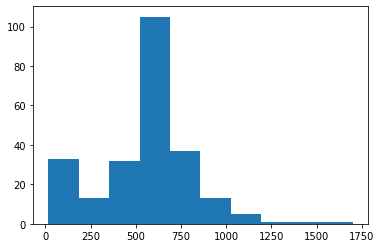

In [10]:
# for each student this is list of numerical id's for the URLs (pages) - removing duplicates
def get_trajectory(df):
    order = [0]
    # Q: order column corresponds to the "from" column (url page) bc 'to' column changes.
    for url in df['order']:
        if url != order[-1]:
            order.append(url)
    order.append(0)
    return order

trajectories = []
# order_to_url maps the order column from session level to the url page in the 
# order column does not exist in aggregate edge list
order_to_url = {0:None}


#for fname in glob('data/MITxPRO+LASERxB1+1T2019-stdAgg-edgeList-sessionLevel-1.csv'):
df = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/edges/MITxPRO+LASERxB1+1T2019-stdAgg-edgeList-sessionLevel-1.csv')
# this is a check to see if this url (module content) exists in 
# display(df[df['from']=='0120d60dd7c74a658f369244cc09a745'])
# temp_dict is helper dictionary 
temp_dict = dict(zip(df['order'], df['from']))
order_to_url.update(temp_dict)
trajectories.append(df)
    
trajectories = pd.concat(trajectories)
trajectories = trajectories.groupby('user_id').apply(get_trajectory)
traj_lengths = trajectories.map(len).values

plt.hist(traj_lengths)
max(traj_lengths)
print(order_to_url)
trajectories

In [ ]:
# num_matrix_elements = len(trajectories)
# #dtw.distance(trajectories.values[0], trajectories.values[1])
# distance_matrix = np.zeros((num_matrix_elements, num_matrix_elements))
# for i in range(num_matrix_elements):
#     for j in range(i+1, num_matrix_elements):
#         value = dtw.distance(trajectories.values[i], trajectories.values[j])
#         distance_matrix[i,j] = value
#         distance_matrix[j,i] = value
# np.save("distance matrix", distance_matrix)

In [11]:
vectorizer = CountVectorizer(ngram_range=[2,2])

url_counts = vectorizer.fit_transform(list(trajectories.apply(lambda x : " ".join([str(url) for url in x]))))
len(vectorizer.get_feature_names())
#list(url_counts.toarray()[0])

6199

In [12]:
#distance_matrix = np.load('distance matrix.npy')
k = 2
# choose medoid 2 and 4 in your C1 and C2 because min(D) in their cluster

# Run cluster analysis and obtain results.
# kmedoids_instance.process()
kmedoids = KMedoids(n_clusters = k).fit(url_counts)
kmedoids.labels_

labels = pd.DataFrame(kmedoids.labels_)
labels['index'] = trajectories.index
labels.to_csv('LaaL kmedoids 2 clusters.csv', header = ['cluster id', 'user id'], index = False)


# clusters = []
# for i in range(k):
#     clusters.append([])
# for i, label in enumerate(kmedoids.labels_):
#     clusters[label].append(trajectories.index[i])
# #output is "typical path(s)" that describe different clusters i.e. exemplar trajectories
# # centers = kmedoids_instance.get_medoids() 
# print(clusters)
# # centers

In [13]:
#these are the users that are the exeplars in each cluster
kmedoids.medoid_indices_
for i in kmedoids.medoid_indices_:
    print(trajectories.index[i])

#kmedoids.medoid_indices_.to_csv('exemplars for 2-medoid clusters', header = ['user id'], index = False)

22855678
11615808


In [ ]:
# these are just the edges from the examplars in the clusters
# looping through 
exemplar_edges = []
for exemplar in centers:
    # below line drops the last point on the first one, and last point on second one
    # line below: looping through pairs of items in the trajectory.  the pairs have id
    # numbers (indices).
    for edge in zip(trajectories.values[exemplar][:-1], trajectories.values[exemplar][1:]):
        # unpack those two items in the in the pair, and convert them from idex id
        # to url name, and put them back together as a pair.
        edges.append((order_to_url[edge[0]], order_to_url[edge[1]]))
    exemplar_edges.append(edges)

with open('exemplar_edges.csv', 'w') as f_out:
        for i, exemplar in enumerate(exemplar_edges):
            #print(exemplar)
            for edge in exemplar:
                # pair and i = exemplar id
                print(edge[0], edge[1], i, file=f_out, sep=',')
    

In [ ]:
for j, cluster in enumerate(clusters):
    subset = trajectories.iloc[cluster]
    edges = []
    for traj in len(subset):
        for edge in zip(subset.values[traj][:-1], subset.values[traj][1:]):
            edges.append((order_to_url[edge[0]], order_to_url[edge[1]])) 

    with open('cluster_{}_edges.csv'.format(j), 'w') as f_out:
        for edge in edges:
            #print(edge)
            print(edge[0], edge[1], j, file=f_out, sep=',')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 30)          33630     
_________________________________________________________________
lstm (LSTM)                  (None, None, 30)          7320      
_________________________________________________________________
dense (Dense)                (None, None, 1121)        34751     
Total params: 75,701
Trainable params: 75,701
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 800 steps
Epoch 1/3
628/800 [======================>.......] - ETA: 2:56 - loss: 5.8824 - acc: 0.0167

KeyboardInterrupt: 

In [5]:
# learning pathway network edge lists - edge list for each student in the course that represent a directed 
# transitions networks  of students pathway through the courses content modules.  this is all students.
AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
AM_edgelist[:5]

,source,target,stds,weight_c,dis,sl
0,00c23be7a0584af395428ab3a704e552,0e3c2d8cac1e44af8bd7fabc48f8d079,8,8,1,0
1,00c23be7a0584af395428ab3a704e552,1f5002403e13485da7e7b1f5896e81ee,3,4,-5,0
2,00c23be7a0584af395428ab3a704e552,9af4973779c443ac986aa5b2a63462d6,3,4,-1,0
3,00c23be7a0584af395428ab3a704e552,aedac84ad12f487db1c88dbe3c82abde,1,1,-18,0
4,00c23be7a0584af395428ab3a704e552,c8a31966713e4ef18f4f06cd4a79d374,1,1,2,0


In [7]:
#pos=nx.kamada_kawai_layout(G)
# plt.figure(figsize=(12,12))
# nx.draw(G, node_size=10)
# plt.show()

In [8]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

,id,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,401ee1f6f3684be7b6124490f34adc5a,MITxPRO+AMxB+1T2018,html,1,b9dd2cb6d3a44e96aedb515388e02405,5589ca87f02147ec8452cead30cc4d5f,57c4192d1f714350848b1424ce840c75,907,2300
1,27bf430c96cb4d8da7368c4697de187b,MITxPRO+AMxB+1T2018,html,2,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,922,1853
2,0fec97a46b71456d9d9037e5edac7bb0,MITxPRO+AMxB+1T2018,html,3,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,723e01f988ce423a9e517f0fc55c8c4f,26,29
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,MITxPRO+AMxB+1T2018,problem,4,3237e864a8b44a14b443a0f0a2067c83,a43d4c2220e245c5bb6ef4649f6813e5,9546e9f7f20c4bf2b09c7c839fd67571,930,5195
4,04d85100616943f8a3d2b084f403ba5f,MITxPRO+AMxB+1T2018,html,5,3e2b8f40ac004d56a2e85e503e0e635b,b4100fe285a442a2ba6de2e94b28642b,6fddc8e62a094b818e30327c45ebf7f3,928,2750
...,...,...,...,...,...,...,...,...,...
750,5b42266d225e4a83bcf7833af7143417,MITxPRO+AMxB+1T2018,html,751,476998cc999c4312b392d128c14cab9b,2c093467e9d54014a0d4f00f7abf931c,71d13483bea1443e83f02d4b036c404e,560,1739
751,253c3d95e42f47a192997f25c3fd5881,MITxPRO+AMxB+1T2018,html,752,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,cc2f936f1afc4df0bb4bf7fa943b1d97,788,2567
752,7d262be6d9b74836b47447db1b70289d,MITxPRO+AMxB+1T2018,problem,753,476998cc999c4312b392d128c14cab9b,2c65103bd7354b0197b703923254f20f,c3e12647605f4894ab69df903b567bf2,774,4682
753,024fed17849e4d60bfc86afa47ce9cb4,MITxPRO+AMxB+1T2018,html,754,4022bcb994a3447a9c609f4ce5bd9016,9852b66b25d14ec0b379bc6532e1753c,e4cd156124f04c1ab2c7fbeead3afa35,0,0


In [9]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chpModLabel,seqModLabel,In-Degree,Out-Degree,Degree
0,401ee1f6f3684be7b6124490f34adc5a,1594.1262f,1048.7539f,MITxPRO+AMxB+1T2018,html,1,907,2300,"Entrance Survey (5 min, required)",Entrance Survey-Html,16,14,30
1,27bf430c96cb4d8da7368c4697de187b,1580.7435f,1018.63403f,MITxPRO+AMxB+1T2018,html,2,922,1853,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,10,8,18
2,0fec97a46b71456d9d9037e5edac7bb0,1598.8334f,1135.2795f,MITxPRO+AMxB+1T2018,html,3,26,29,"Pre-Assessment (10 min, required)",Pre-Assessment-Html,2,2,4
3,9b9fc7fd30954d7d9ad7d8f8e1cc11d8,1549.503f,1036.6296f,MITxPRO+AMxB+1T2018,problem,4,930,5195,"Pre-Assessment (10 min, required)",Pre-Assessment Completion Confirmation,5,7,12
4,04d85100616943f8a3d2b084f403ba5f,1505.2043f,1015.3352f,MITxPRO+AMxB+1T2018,html,5,928,2750,Get Started (25 min),Welcome-Html,19,14,33


In [10]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance[:5]

,id,percent_grade,date_joined,enroll_created_date,cert_status,certGrp
0,14172563,0.65,3/24/2017 14:25,3/8/2018 17:31,Pass,Not certified (> 70% Grade)
1,18373780,0.79,3/8/2018 17:49,3/8/2018 17:49,Pass,Certified (< 70% Grade)
2,15779327,0.80,8/28/2017 20:48,3/8/2018 18:07,Pass,Certified (< 70% Grade)
3,18373985,0.91,3/8/2018 18:08,3/8/2018 18:08,Pass,Certified (< 70% Grade)
4,18374076,0.16,3/8/2018 18:15,3/8/2018 18:15,NaN,Not certified (> 70% Grade)


In [11]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

,id,metadata.display_name,category,metadata.start,metadata.end
0,MITxPRO+LASERxB1+1T2019,"Strategy, Products, Capability Work, and Teams",course,2019-03-09 01:00:00,2019-04-09 23:59:00


In [12]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data
# problem UTF-encoding error

# LaaL_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [13]:
LaaL_edelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

,from,to,stds,weight,dis,sl
0,001339db8ced4cf78829ebe8b145449d,001339db8ced4cf78829ebe8b145449d,179,1096,0,1
1,001339db8ced4cf78829ebe8b145449d,452745e0366e42ae81561bfddebcc6c3,177,179,1,0
2,001339db8ced4cf78829ebe8b145449d,4660ff2089114e8db82ceb26a4f329e3,2,2,2,0
3,001339db8ced4cf78829ebe8b145449d,901e92500aea43c79f19f1b279050668,4,4,-1,0
4,00ae5f0c51874a73a41ebea838d95682,00ae5f0c51874a73a41ebea838d95682,119,383,0,1


In [14]:
LaaL_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

,name,courseID,mod_type,order,chpModPar,seqModPar,vrtModPar,stds,count
0,b613861cecf84ffcab01afb23f660475,MITxPRO+LASERxB1+1T2019,problem,1,41ad78dff2594088a4eb8b6b7ce406f3,c1b52a1ef69a404ea9132e95ad25093a,4aea5151404640ac8ebe81deff85def0,241,1610
1,e2911e79efc2420eac45d9f671463d4b,MITxPRO+LASERxB1+1T2019,problem,2,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,1686
2,519d1b8c59404d67b54e96c5c8a830b2,MITxPRO+LASERxB1+1T2019,problem,3,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,592
3,531db53f81f646edb0cdcfe0085b03b7,MITxPRO+LASERxB1+1T2019,problem,4,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,566
4,4f5f94b2f95141e0a9d53a61da2276da,MITxPRO+LASERxB1+1T2019,problem,5,41ad78dff2594088a4eb8b6b7ce406f3,c07316dff77348caa08e94ddaed4bec3,0a393e10d08c453ea9659c51826bd65e,241,571


In [15]:
LaaL_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

,id,x,y,courseID,mod_type,order,stds,count,chapterModLabel,In-Degree,Out-Degree,Degree
0,b613861cecf84ffcab01afb23f660475,-882.02423f,2054.1257f,MITxPRO+LASERxB1+1T2019,problem,1,241,1610,Week 0: Get Started (40 min),22,23,45
1,e2911e79efc2420eac45d9f671463d4b,-758.68823f,2250.8474f,MITxPRO+LASERxB1+1T2019,problem,2,241,1686,Week 0: Get Started (40 min),23,21,44
2,519d1b8c59404d67b54e96c5c8a830b2,-902.5562f,2516.3157f,MITxPRO+LASERxB1+1T2019,problem,3,241,592,Week 0: Get Started (40 min),5,7,12
3,531db53f81f646edb0cdcfe0085b03b7,-943.9201f,2620.5632f,MITxPRO+LASERxB1+1T2019,problem,4,241,566,Week 0: Get Started (40 min),5,5,10
4,4f5f94b2f95141e0a9d53a61da2276da,-963.7683f,2726.7637f,MITxPRO+LASERxB1+1T2019,problem,5,241,571,Week 0: Get Started (40 min),5,8,13


In [16]:
LaaL_id_and_performance = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]

,id,percent_grade,date_joined,enroll_created_date,cert_status,certGrp
0,11686401,0.38,8/23/2016 22:41,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
1,15603897,0.02,8/14/2017 13:53,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
2,11382474,0.40,7/22/2016 12:46,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
3,20757153,0.02,9/17/2018 17:15,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
4,11615808,0.34,8/16/2016 20:59,3/8/2019 1:31,NaN,Not certified (> 65% Grade)
